# Comparison TPV tracks and MCS observations 

In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy
import cartopy.crs as ccrs
from tpv_analysis import get_tracks, check_overlap, check_overlap_tcs
import warnings
warnings.filterwarnings('ignore')

## Get TPV tracks 

In [47]:
filename='tpv_files_JuliaK/tpv_2010.real_time'
tpv = get_tracks(filename, 2010)


## Get MCS tracks 

In [48]:
# read in CTT tracks heavy rain core 
tbb = '/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/tcs/Tracks_2010_heavyraincore3mm.h5'
mcs= pd.read_hdf(tbb, 'table')
mcs.timestr = pd.to_datetime(mcs.timestr) 

## Overlap check for 15 years of TCS and TPV  

In [2]:
total_mcs= np.zeros((15,))
total_tpv= np.zeros((15,))
total_overlap= np.zeros((15,))
total_overlap_off= np.zeros((15,))
total_mcsoverlap= np.zeros((15,))
total_mcsoverlap_off= np.zeros((15,))
cellcount_mcs = np.zeros((15,))
cellcount_tpv = np.zeros((15,))
mcs_check= 0 

for y in np.arange(2001,2016):
    # tpv data 
    filename='tpv_files_JuliaK/tpv_' + str(y)+'.real_time'
    tpv = get_tracks(filename, y)
    
    # mcs data 
    tbb = '/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/tcs/Tracks_'+ str(y)+ '_heavyraincore3mm.h5'
    mcs= pd.read_hdf(tbb, 'table')
    mcs.timestr = pd.to_datetime(mcs.timestr) 
    
    # overlap check 
    i = y - 2001
    mcs_count, mcs_count_off, tpv_no_mcs, mcs_no_tpv, all_mcs, all_tpv, overlap_mcs, overlap_mcs_off = check_overlap_tcs(tpv,mcs)
    total_overlap[i] = np.shape(mcs_count[mcs_count > 0])[0]
    total_overlap_off[i] =  np.shape(mcs_count_off[mcs_count_off > 0])[0] 
    
    total_mcsoverlap[i] = overlap_mcs
    total_mcsoverlap_off[i] =  overlap_mcs_off
    
    total_tpv[i] =  tpv_no_mcs
    total_mcs[i] =  mcs_no_tpv
    
    # for check 
    cellcount_mcs[i] = all_mcs 
    cellcount_tpv[i] = all_tpv

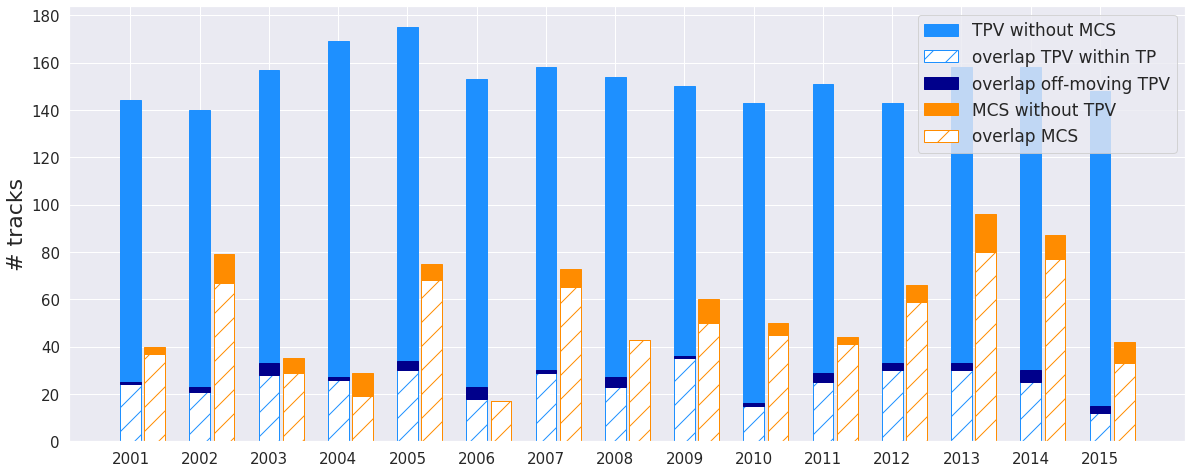

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()
plt.figure(figsize= (20,8))
years = np.arange(2001,2016)
w = 0.3
# TPV 
plt.bar(years, cellcount_tpv, edgecolor = 'dodgerblue', color = 'dodgerblue', label= 'TPV without MCS', width =w)
plt.bar(years,  total_overlap, edgecolor = 'dodgerblue', color = 'white', hatch = '/', label = 'overlap TPV within TP', width =w)
plt.bar(years,  total_overlap_off, bottom = total_overlap, edgecolor ='darkblue' ,color = 'darkblue',label = 'overlap off-moving TPV', width =w)


# MCS 
plt.bar(years + 0.35, cellcount_mcs,edgecolor = 'darkorange', color = 'darkorange', label = 'MCS without TPV', width =w)
plt.bar(years+ 0.35, cellcount_mcs - total_mcs , edgecolor = 'darkorange', color ='white',  hatch = '/', label = 'overlap MCS', width =w)

plt.xticks(years, fontsize= 15)
plt.yticks(np.arange(0,200,10)[::2], fontsize= 15)
plt.legend(fontsize= 17)

plt.ylabel('# tracks', fontsize= 22)
plt.savefig('TCS_and_TPV.png')
plt.show()

- many occurrences of TPV without any MCS over the TP 
- little MCS without the occurrence of TPV (mostly non-off moving)
- probably due to the high frequency of TPV occurrences (every 3rd day)

## Comparison between off-mocing TPV and off-moving MCS 

In [6]:
tpb_east = pd.read_hdf('../CTT/analysis/TPB_east_cells.h5', 'table')

In [2]:
tpv = get_tracks('tpv_files_JuliaK/tpv_2001.real_time', 2001)
for y in np.arange(2002,2016):
    # tpv data 
    filename='tpv_files_JuliaK/tpv_' + str(y)+'.real_time'
    tracks = get_tracks(filename, y)
    tpv = tpv.append(tracks)

In [3]:
# drop cells that are not off-moving 
tpv_off = pd.DataFrame(columns = tpv.columns)
for y in np.arange(2000,2016):
    subset= tpv[tpv.time.dt.year == y]
    for cell in np.unique(subset.id.values):
        if subset[subset.id == cell].lon.values[-1] >= 105:
            tpv_off= tpv_off.append(subset[subset.id == cell])

In [7]:
# get only cells over Sichuan basin 
mcs_off = tpb_east[(tpb_east.longitude >= 100) &(tpb_east.longitude <= 110) &(tpb_east.latitude > 25)]

In [8]:
total_mcs= np.zeros((15,))
total_tpv= np.zeros((15,))
total_overlap= np.zeros((15,))
total_mcsoverlap= np.zeros((15,))
cellcount_mcs = np.zeros((15,))
cellcount_tpv = np.zeros((15,))

for y in np.arange(2001,2016):
    # tpv data 
    tpv = tpv_off[tpv_off.time.dt.year == y]
    
    # mcs data 
    mcs = mcs_off[mcs_off.time.dt.year == y]
    
    # overlap check 
    i = y - 2001
  
    tpv_overlap, tpv_no_mcs, mcs_no_tpv, all_mcs, all_tpv, mcs_overlap = check_overlap(tpv,mcs)
    total_overlap[i] = np.shape(tpv_overlap[tpv_overlap > 0])[0]
    total_mcsoverlap[i] = mcs_overlap
    # cases with no overlap 
    total_tpv[i] =  tpv_no_mcs
    total_mcs[i] =  mcs_no_tpv
    # total numbers for check 
    cellcount_mcs[i] = all_mcs 
    cellcount_tpv[i] = all_tpv

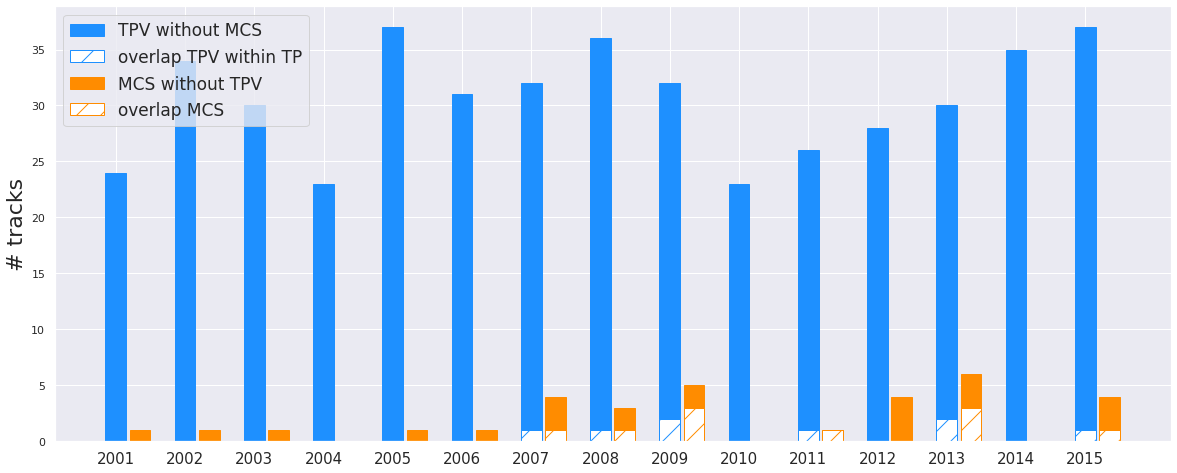

In [10]:
import seaborn as sns 
sns.set()
plt.figure(figsize= (20,8))
years = np.arange(2001,2016)
w = 0.3
# TPV 
plt.bar(years, cellcount_tpv, edgecolor = 'dodgerblue', color = 'dodgerblue', label= 'TPV without MCS', width =w)
plt.bar(years,  total_overlap, edgecolor = 'dodgerblue', color = 'white', hatch = '/', label = 'overlap TPV within TP', width =w)


# MCS 
plt.bar(years + 0.35, cellcount_mcs, edgecolor = 'darkorange', color = 'darkorange', label = 'MCS without TPV', width =w)
plt.bar(years+ 0.35, cellcount_mcs - total_mcs , edgecolor = 'darkorange', color ='white',  hatch = '/', label = 'overlap MCS', width =w)

plt.xticks(years, fontsize= 15)
#plt.yticks(np.arange(0,20,10)[::2], fontsize= 15)
plt.legend(fontsize= 17)

plt.ylabel('# tracks', fontsize= 22)
plt.savefig('TCS_and_TPV_off.png')
plt.show()

In [9]:
total_mcsoverlap.sum()

13.0

In [22]:
total_mcsoverlap.sum()/ cellcount_mcs.sum() * 100 

31.25

- check relationship between overlaps (do stronger TPV lead to stronger MCS? )
- check what are the TPV that have multiple MCS associated with it 
- compare only strong TPV or only TPV with more rain associated 


**- TPV (moving off) and TPB east/MCS initiated in Sichuan basin (lat > 25N, lon< 110 E )**
- 10 from 32 MCS have a time overlap with the TPV 